In [1]:
%matplotlib notebook
import numpy as np
import helpers
import pandas as pd
import matplotlib as mpl
import scipy.signal
import mne
from itertools import cycle
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['figure.max_open_warning'] = 30

select results file and get necessary parameters

In [5]:
# trialregs_dot = 0
# resfile = helpers.resultsdir + '/meg_sequential_201703011624.h5'

# trialregs_dot = 0, baseline = None
# resfile = helpers.resultsdir + '/meg_sequential_201703161743.h5'

# trialregs_dot = 5, baseline = None
# resfile = helpers.resultsdir + '/meg_sequential_201703161307.h5'

# trialregs_dot = 5
# resfile = helpers.resultsdir + '/meg_sequential_201703011927.h5'

# trialregs_dot = 0, baseline = None, choice flipped dot_x and accev
# resfile = helpers.resultsdir + '/meg_sequential_201705311314.h5'

# source GLM, trialregs_dot = 5, baseline = (-0.3, 0), choice flipped dot_x and accev
# resfile = helpers.resultsdir + '/source_sequential_201706141650.h5'

# source GLM, trialregs_dot = 5, baseline = (-0.3, 0), choice flipped dot_x and accev, move_dist, sum_dot_y_prev
# resfile = helpers.resultsdir + '/source_sequential_201706191442.h5'

# source GLM, trialregs_dot = 5, baseline = (-0.3, 0), choice flipped dot_x and accev, move_dist, sum_dot_y_prev
# constregs=0 for 1st dot
resfile = helpers.resultsdir + '/source_sequential_201706201654.h5'

#evoked = helpers.load_evoked_container(window=pd.read_hdf(resfile, 'window'))
evoked = helpers.load_evoked_container(window=[0, 0.9])

Reading data/meg_final_data/evoked_sfreq100.0_window0.00-0.90_mag-ave.fif ...
    Found the data of interest:
        t =       0.00 ...     890.00 ms (Unknown)
        0 CTF compensation matrices available
        nave = 480 - aspect type = 100
No baseline correction applied


plotting functions

In [3]:
stylecycler = cycle([':', '--', '-.'])
def plot_minmax_regressors(results, r_names, measure, nperm=0, mode='absmax'):
    if mode == 'max':
        ax = results.xs(measure, axis=1, level='measure').xs(0, level='permnr').max(
            level='time').plot(y=r_names);
    elif mode == 'min':
        ax = results.xs(measure, axis=1, level='measure').xs(0, level='permnr').min(
            level='time').abs().plot(y=r_names);
    elif mode == 'absmax':
        ax = results.xs(measure, axis=1, level='measure').xs(0, level='permnr').abs(
            ).max(level='time').plot(y=r_names)
    elif mode == 'absmean':
        ax = results.xs(measure, axis=1, level='measure').xs(0, level='permnr').abs(
            ).mean(level='time').plot(y=r_names)
        
    cols = [l.get_color() for l in ax.get_lines()]

    nperm += 1
    
    for perm in perms[1:nperm]:
        if mode == 'max':
            results.xs(measure, axis=1, level='measure').xs(perm, level='permnr').max(
                level='time').plot(y=r_names, ax=ax, 
                style=[next(stylecycler)] * len(r_names))
        elif mode == 'min':
            results.xs(measure, axis=1, level='measure').xs(perm, level='permnr').min(
                level='time').abs().plot(y=r_names, ax=ax, 
                style=[next(stylecycler)] * len(r_names))
        elif mode == 'absmax':
            results.xs(measure, axis=1, level='measure').xs(perm, level='permnr').abs(
                ).max(level='time').plot(y=r_names, ax=ax, 
                style=[next(stylecycler)] * len(r_names))
        elif mode == 'absmean':
            results.xs(measure, axis=1, level='measure').xs(perm, level='permnr').abs(
                ).mean(level='time').plot(y=r_names, ax=ax, 
                style=[next(stylecycler)] * len(r_names))

    lines = ax.get_lines()
    for i in range(len(r_names)):
        col = lines[i].get_color()
        for perm in perms[1:nperm]:
            lines[i + perm * len(r_names)].set_color(col)

def show_topology_at_peaks(results, r_name, measure, mode='absmax', order=4, vmin=-.1, vmax=.1):
    if mode == 'absmax':
        data = results.loc[0, (measure, r_name)].abs().max(level='time')
    elif mode == 'absmean':
        data = results.loc[0, (measure, r_name)].abs().mean(level='time')
    elif mode == 'max':
        data = results.loc[0, (measure, r_name)].max(level='time')
    else:
        data = results.loc[0, (measure, r_name)].min(level='time').abs()
    
    plt.figure()
    ax = data.plot(title=measure);
    
    # identify local maxima
    times = data.index[scipy.signal.argrelextrema(data.values, 
                                                  np.greater, order=order)] / 1000
    
    data = results.loc[0, (measure, r_name)]
    ev = mne.EvokedArray(data.values.reshape(102, data.index.levels[1].size), 
                         evoked.info, tmin=data.index.levels[1][0], 
                         nave=480*5, comment=r_name)
    
    fig = ev.plot_topomap(times, scale=1, vmin=vmin, vmax=vmax, image_interp='nearest', 
                          title=r_name+' aligned to dot onset', unit=measure, 
                          outlines='skirt');
    

def plot_single_signal(fl_data, sl_data, label, r_name, ax=None):
    dat = fl_data.loc[(0, label, slice(None)), 
                      (slice(None), 'beta', r_name)]
    times = dat.index.get_level_values('time')
    
    if ax is None:
        fig, ax = plt.subplots()
        
    l = ax.plot(times, dat, color='.7', label='single subjects')
    l1 = ax.plot(times, sl_data.loc[(slice(1,3), label, slice(None)), ('mean', r_name)]
                               .reset_index('permnr')
                               .pivot(columns='permnr'), 
                 ':k', label='mean (permuted data)')
    l2 = ax.plot(times, sl_data.loc[(0, label, slice(None)), ('mean', r_name)], 
                 'k', lw=2, label='mean')
    
    ax.legend([l[0], l1[0], l2[0]], ['single subjects', 'mean (permuted data)', 'mean']);
    ax.set_title(label)
    ax.set_xlabel('time from dot onset (ms)')
    ax.set_ylabel('beta of ' + r_name + ' (z)')

# Second level analysis

this scales the betas by their standard error and then averages across subjects to get the second level mean

In [22]:
first_level = pd.read_hdf(resfile, 'first_level')
flt = (  first_level.xs('beta', level='measure', axis=1) 
       / first_level.xs('bse', level='measure', axis=1))
second_level = pd.concat([flt.mean(level='regressor', axis=1), 
                          flt.std(level='regressor', axis=1)], keys=['mean', 'std'], names=['measure'], axis=1)

del flt
perms = second_level.index.levels[0]
second_level.head()

measure                 mean                                             \
regressor          abs_dot_x abs_dot_y     accev accev_cflip accsur_pca   
permnr label  time                                                        
0      ???-lh 0     0.087355 -0.100528 -0.062214    0.264611   0.099066   
              10    0.166942  0.025943  0.169900    0.193710   0.097322   
              20    0.371010 -0.048519  0.356238    0.166157   0.153253   
              30    0.189898 -0.112876  0.362569    0.271437   0.012223   
              40    0.231926  0.044882  0.229657    0.215514  -0.054948   

measure                                                                 \
regressor              dot_x dot_x_cflip     dot_y   entropy intercept   
permnr label  time                                                       
0      ???-lh 0     0.000500    0.017208 -0.130726  0.062735 -1.676842   
              10    0.140870   -0.264545  0.105990 -0.000819 -1.754952   
              20    0.049488   -0.372865  0.014465 -0.161643 -1.646588   
              30   -0.283067   -0.227080 -0.031868 -0.280868 -1.478291   
              40    0.025919   -0.303753  0.056394 -0.172998 -1.159752   

measure               ...            std                                  \
regressor             ...     accsur_pca     dot_x dot_x_cflip     dot_y   
permnr label  time    ...                                                  
0      ???-lh 0       ...       1.027317  1.024554    0.908883  0.938980   
              10      ...       0.824086  0.823997    0.818990  1.026524   
              20      ...       0.878299  0.749131    0.932595  1.017729   
              30      ...       0.934397  1.006845    0.983444  0.987322   
              40      ...       0.795220  0.967898    1.041758  1.086454   

measure                                                                    \
regressor            entropy intercept move_dist  response sum_dot_y_prev   
permnr label  time                                                          
0      ???-lh 0     1.374405  2.532190  0.926909  0.648255       1.207754   
              10    1.211606  2.580226  0.881321  0.893315       1.415058   
              20    1.232729  2.594275  1.086977  1.019795       1.510209   
              30    1.427302  2.495427  0.966252  1.059998       1.354028   
              40    1.183282  2.548019  0.872731  0.810982       1.301308   

measure                        
regressor          trial_time  
permnr label  time             
0      ???-lh 0      2.123267  
              10     2.183659  
              20     2.490942  
              30     2.423201  
              40     2.505543  

[5 rows x 28 columns]

standard analysis: average betas across subjects to get the second level mean

In [27]:
first_level = pd.read_hdf(resfile, 'first_level')
sl2 = pd.read_hdf(resfile, 'second_level')
perms = second_level.index.levels[0]
sl2.head()

measure                 mean                                             \
regressor          abs_dot_x abs_dot_y     accev accev_cflip accsur_pca   
permnr label  time                                                        
0      ???-lh 0     0.001240 -0.001000 -0.001022    0.002656   0.001304   
              10    0.001908  0.000414  0.002163    0.002036   0.001204   
              20    0.004505 -0.000647  0.004362    0.002002   0.001910   
              30    0.002210 -0.001361  0.004284    0.003322   0.000155   
              40    0.002622  0.000544  0.002772    0.002661  -0.000853   

measure                                                                 \
regressor              dot_x dot_x_cflip     dot_y   entropy intercept   
permnr label  time                                                       
0      ???-lh 0    -0.000047    0.000660 -0.001392  0.002916 -0.018560   
              10    0.001706   -0.002838  0.000945  0.001551 -0.019938   
              20    0.000799   -0.004573 -0.000275 -0.004467 -0.018714   
              30   -0.003120   -0.002920 -0.000582 -0.005278 -0.017215   
              40    0.000212   -0.003794  0.000446 -0.002635 -0.013608   

measure               ...            std                                  \
regressor             ...     accsur_pca     dot_x dot_x_cflip     dot_y   
permnr label  time    ...                                                  
0      ???-lh 0       ...       0.013388  0.011615    0.011170  0.010139   
              10      ...       0.010574  0.009404    0.010179  0.011354   
              20      ...       0.011309  0.008845    0.011356  0.011390   
              30      ...       0.012606  0.011512    0.012398  0.010533   
              40      ...       0.010805  0.011393    0.013266  0.011895   

measure                                                                    \
regressor            entropy intercept move_dist  response sum_dot_y_prev   
permnr label  time                                                          
0      ???-lh 0     0.039113  0.029481  0.013776  0.016292       0.013808   
              10    0.035997  0.030284  0.012708  0.022287       0.016241   
              20    0.036046  0.030163  0.015639  0.025977       0.017519   
              30    0.048559  0.029381  0.014352  0.026224       0.015511   
              40    0.038534  0.029631  0.013111  0.020274       0.014977   

measure                        
regressor          trial_time  
permnr label  time             
0      ???-lh 0      0.050753  
              10     0.053034  
              20     0.061016  
              30     0.059732  
              40     0.061001  

[5 rows x 42 columns]

In [30]:
tvals2 = (sl2.xs('mean', axis=1, level='measure')  / 
         sl2.xs('std', axis=1, level='measure') * np.sqrt(34))
tvals2['accev'] = -tvals2['accev']

In [61]:
abserr = (tvals.xs(0, level='permnr') - tvals2.xs(0, level='permnr')).abs()
abserr.describe()

regressor,abs_dot_x,abs_dot_y,accev,accev_cflip,accsur_pca,dot_x,dot_x_cflip,dot_y,entropy,intercept,move_dist,response,sum_dot_y_prev,trial_time
count,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000
mean,0.088240,0.080609,0.098850,0.100254,0.109570,0.092516,0.088185,0.080986,0.169891,0.089916,0.083991,0.088895,0.082037,0.085769
std,0.075996,0.072934,0.081965,0.081856,0.090724,0.078296,0.073372,0.072398,0.130949,0.071477,0.073343,0.080433,0.074937,0.076942
min,0.000008,0.000003,0.000003,0.000002,0.000003,0.000007,0.000018,0.000009,0.000017,0.000004,0.000007,0.000016,0.000003,0.000008
25%,0.032382,0.029318,0.037716,0.038665,0.042316,0.035034,0.033298,0.030264,0.068150,0.036206,0.032267,0.031636,0.030852,0.030742
50%,0.069830,0.063229,0.080394,0.081193,0.088935,0.074006,0.070772,0.064250,0.142562,0.074606,0.067800,0.069065,0.065562,0.065929
75%,0.124331,0.111718,0.139175,0.141060,0.154130,0.128622,0.124828,0.111642,0.242335,0.125523,0.116134,0.123097,0.113695,0.118798
max,0.825517,1.151476,1.111814,1.075836,1.175400,0.905626,0.667658,1.469985,1.116674,0.606442,1.791998,1.398976,1.453284,1.054438


<IPython.core.display.Javascript object>


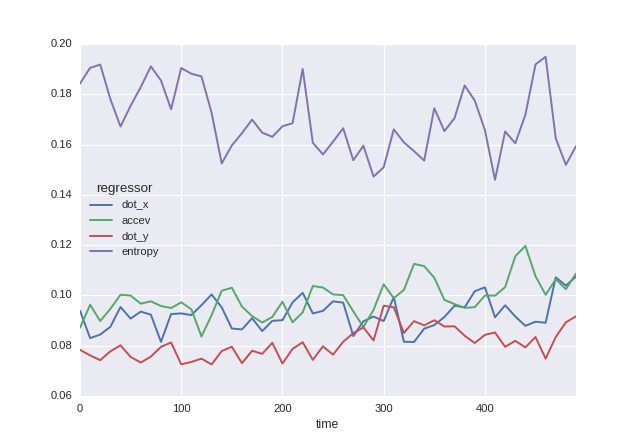

In [63]:
abserr.mean(level='time').plot.line(y=['dot_x', 'accev', 'dot_y', 'entropy']);

<IPython.core.display.Javascript object>


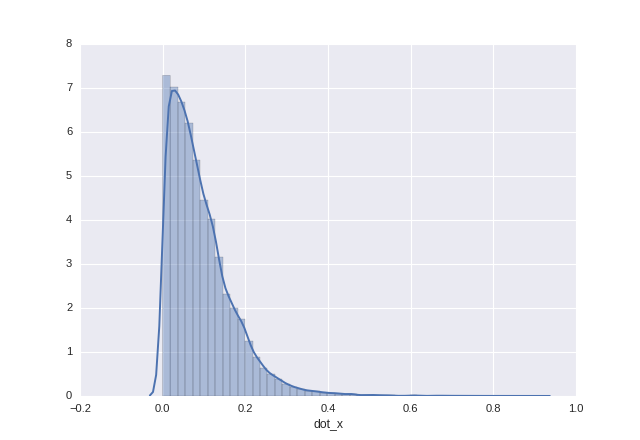

In [64]:
fig, ax = plt.subplots()
sns.distplot(abserr.dot_x);

In [65]:
quantiles = abserr.quantile(np.linspace(0.9, 1, 1000))
quantiles.head()

regressor,abs_dot_x,abs_dot_y,accev,accev_cflip,accsur_pca,dot_x,dot_x_cflip,dot_y,entropy,intercept,move_dist,response,sum_dot_y_prev,trial_time
0.9000,0.184792,0.168260,0.205985,0.209233,0.226904,0.193586,0.182473,0.168345,0.349330,0.184704,0.172781,0.189388,0.169464,0.183331
0.9001,0.184816,0.168276,0.206054,0.209285,0.227113,0.193614,0.182525,0.168395,0.349475,0.184707,0.172858,0.189533,0.169514,0.183441
0.9002,0.184874,0.168286,0.206069,0.209438,0.227212,0.193630,0.182552,0.168463,0.349702,0.184814,0.172954,0.189604,0.169594,0.183498
0.9003,0.184895,0.168306,0.206109,0.209539,0.227383,0.193741,0.182589,0.168504,0.349808,0.184848,0.173027,0.189699,0.169699,0.183535
0.9004,0.184969,0.168331,0.206138,0.209646,0.227414,0.193804,0.182648,0.168587,0.349848,0.184900,0.173052,0.189750,0.169804,0.183553


<IPython.core.display.Javascript object>


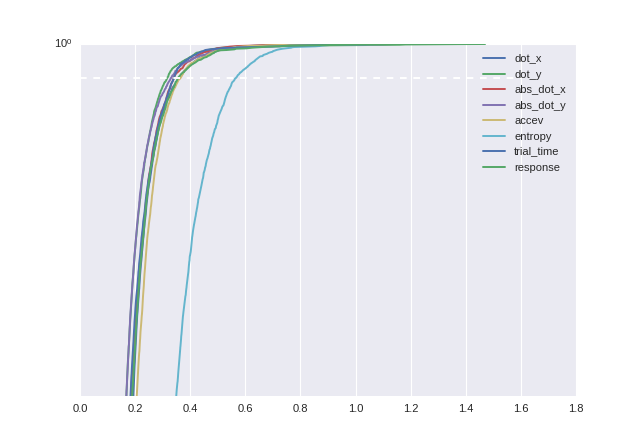

In [67]:
fig, ax = plt.subplots()
regs = ['dot_x', 'dot_y', 'abs_dot_x', 'abs_dot_y', 'accev', 'entropy', 'trial_time', 'response']
ax.semilogy(quantiles[regs], quantiles.index);
ax.plot(ax.get_xlim(), [0.99, 0.99], '--w')
ax.set_ylim(quantiles.index[0], quantiles.index[-1]);
ax.legend(regs);

In [74]:
abserr.shape

(18100, 14)

In [73]:
(abserr > 0.2).sum()

regressor
abs_dot_x         1464
abs_dot_y         1074
accev             1965
accev_cflip       2075
accsur_pca        2561
dot_x             1608
dot_x_cflip       1367
dot_y             1077
entropy           6209
intercept         1414
move_dist         1160
response          1564
sum_dot_y_prev    1056
trial_time        1403
dtype: int64

In [23]:
# Note that these are not exactly the t-values underlying the negative log10 p-values 
# stored in second_level, because scipy.stats uses a different denominator when 
# computing variances and standard deviations than the default used by numpy 
# (N-1 in scipy.stats vs. N in numpy default).
tvals = (second_level.xs('mean', axis=1, level='measure')  / 
         second_level.xs('std', axis=1, level='measure') * np.sqrt(34))
tvals['accev'] = -tvals['accev']

In [24]:
absmean = tvals.xs(0, level='permnr').abs().mean(level='time')

<IPython.core.display.Javascript object>


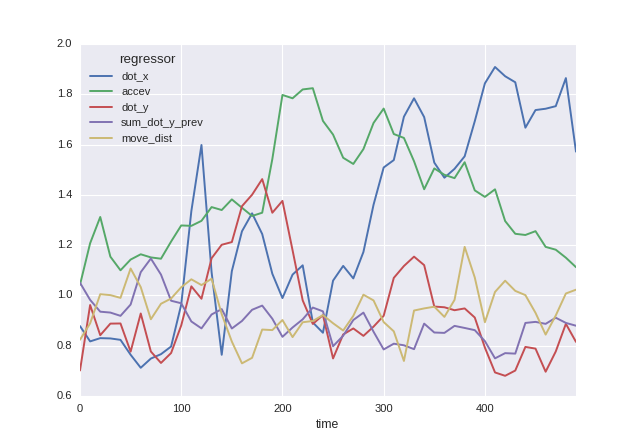

In [20]:
absmean.plot.line(y=['dot_x', 'accev', 'dot_y', 'sum_dot_y_prev', 'move_dist']);

<IPython.core.display.Javascript object>


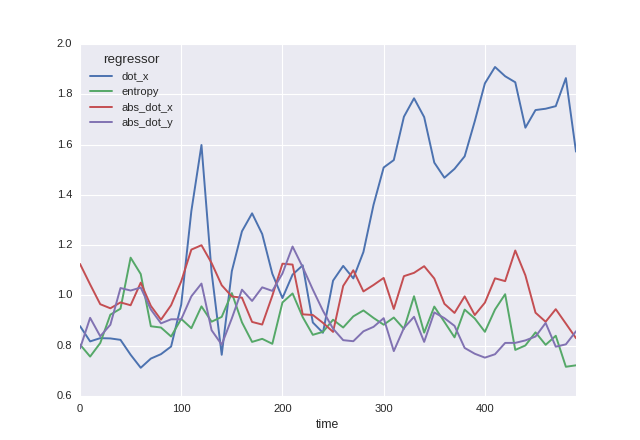

In [21]:
absmean.plot.line(y=['dot_x', 'entropy', 'abs_dot_x', 'abs_dot_y']);

In [54]:
tvals.loc[(0, slice(None), 120), 'abs_dot_x'].abs().sort_values(ascending=False)

permnr  label           time
0       R_V2_ROI-rh     120     5.657435
        R_LIPd_ROI-rh   120     4.140750
        R_VVC_ROI-rh    120     3.785861
        R_PHA3_ROI-rh   120     3.742471
        R_PreS_ROI-rh   120     3.608654
        R_DVT_ROI-rh    120     3.577113
        L_RSC_ROI-lh    120     3.266171
        R_V1_ROI-rh     120     3.229870
        L_OP4_ROI-lh    120     3.218666
        L_IP0_ROI-lh    120     3.217528
        R_PeEc_ROI-rh   120     3.152281
        ???-lh          120     3.147734
        L_V1_ROI-lh     120     3.137779
        L_3a_ROI-lh     120     3.117201
        R_IP1_ROI-rh    120     3.014599
        L_V8_ROI-lh     120     3.008520
        L_PGp_ROI-lh    120     2.948668
        R_v23ab_ROI-rh  120     2.903207
        R_IPS1_ROI-rh   120     2.900775
        R_V3_ROI-rh     120     2.892265
        R_IP0_ROI-rh    120     2.856258
        R_PHA1_ROI-rh   120     2.835017
        R_31pv_ROI-rh   120     2.810335
        R_MIP_ROI-rh    120 

### describe genuine regressors

In [6]:
measure = 'mean'

second_level.xs(measure, axis=1, level='measure').xs(0, level='permnr').describe()

regressor,abs_dot_x,abs_dot_y,accev,accev_cflip,accsur_pca,dot_x,dot_x_cflip,dot_y,entropy,intercept,move_dist,response,sum_dot_y_prev,trial_time
count,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000
mean,0.000066,-0.000155,-0.000021,0.000147,-0.000046,0.000088,0.000032,0.000054,-0.000157,0.001026,0.000283,-0.000141,-0.000156,-0.000281
std,0.004938,0.004318,0.009830,0.005375,0.003920,0.008021,0.003810,0.004433,0.009871,0.023811,0.007196,0.008337,0.004908,0.014960
min,-0.026737,-0.022992,-0.054404,-0.025904,-0.021309,-0.056959,-0.019595,-0.029174,-0.046640,-0.109075,-0.032092,-0.049993,-0.035591,-0.065807
25%,-0.002933,-0.002706,-0.004899,-0.003282,-0.002422,-0.003335,-0.002323,-0.002389,-0.006097,-0.012269,-0.004049,-0.005109,-0.003189,-0.009887
50%,0.000113,-0.000121,-0.000046,0.000128,0.000032,0.000053,-0.000007,-0.000020,-0.000167,0.001369,0.000278,-0.000152,-0.000141,0.000038
75%,0.003096,0.002391,0.005029,0.003507,0.002383,0.003430,0.002424,0.002406,0.005842,0.015249,0.004576,0.004839,0.002841,0.009232
max,0.024671,0.021556,0.051105,0.022641,0.016583,0.051364,0.017650,0.033640,0.045609,0.109145,0.033507,0.040207,0.039449,0.071288


### describe regressors of first permutation

In [7]:
second_level.xs(measure, axis=1, level='measure').xs(1, level='permnr').describe()

regressor,abs_dot_x,abs_dot_y,accev,accev_cflip,accsur_pca,dot_x,dot_x_cflip,dot_y,entropy,intercept,move_dist,response,sum_dot_y_prev,trial_time
count,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000
mean,-0.000030,-0.000018,-0.000024,-0.000039,-0.000005,-0.000013,0.000004,-0.000014,0.000202,0.001023,0.000097,0.000048,0.000041,-0.000023
std,0.003997,0.003626,0.003376,0.003926,0.003850,0.003401,0.003612,0.003232,0.009690,0.023652,0.006987,0.007638,0.003179,0.007173
min,-0.021248,-0.016318,-0.018440,-0.017231,-0.020683,-0.017072,-0.016383,-0.014027,-0.043187,-0.109593,-0.031785,-0.034846,-0.013054,-0.031580
25%,-0.002478,-0.002239,-0.002151,-0.002438,-0.002406,-0.002122,-0.002309,-0.002033,-0.005872,-0.011836,-0.004040,-0.004770,-0.001970,-0.004532
50%,-0.000010,0.000018,-0.000027,-0.000048,0.000019,-0.000011,0.000014,-0.000013,0.000178,0.001359,0.000081,0.000036,0.000038,-0.000063
75%,0.002403,0.002225,0.002100,0.002377,0.002352,0.002101,0.002236,0.002008,0.006216,0.014907,0.004156,0.004815,0.002014,0.004438
max,0.022815,0.017528,0.016046,0.017374,0.018331,0.017955,0.017735,0.018012,0.039951,0.106541,0.030719,0.038463,0.013269,0.032677


## Show evolution of max (across channels) through the trial

principle regressors of interest

<IPython.core.display.Javascript object>


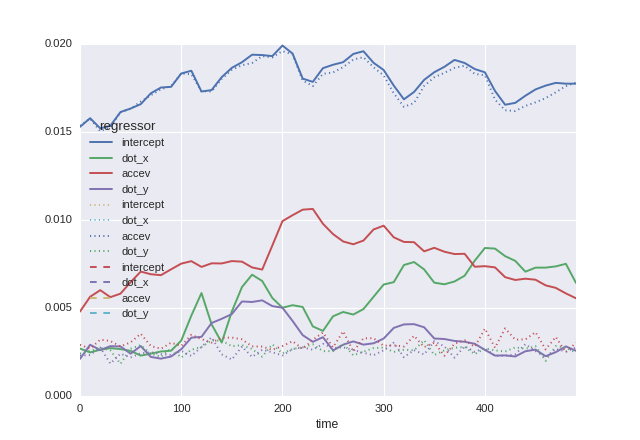

In [9]:
reg = ['intercept', 'dot_x', 'accev', 'dot_y']
measure = 'mean'

plot_minmax_regressors(second_level, reg, measure, nperm=2, mode='absmean')

surprise regressors

<IPython.core.display.Javascript object>


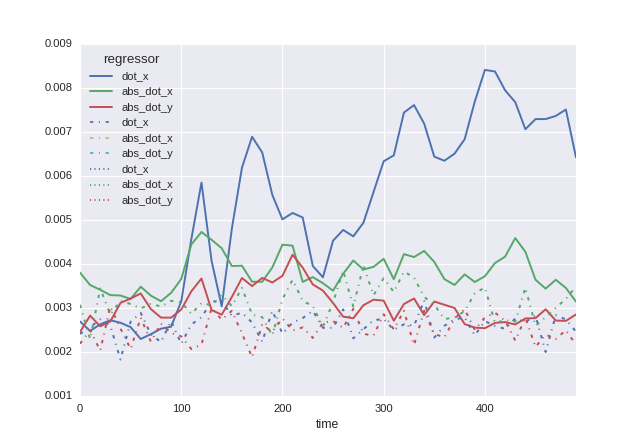

In [10]:
plot_minmax_regressors(second_level, ['dot_x', 'abs_dot_x', 'abs_dot_y'], 
                       measure, nperm=2, mode='absmean')

trial regressors

<IPython.core.display.Javascript object>


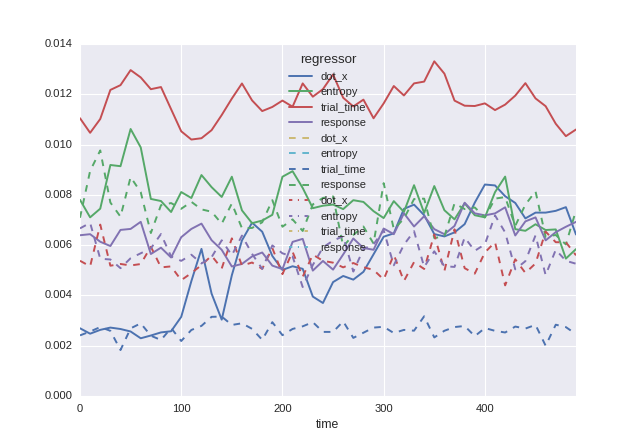

In [11]:
plot_minmax_regressors(second_level, ['dot_x', 'entropy', 'trial_time', 'response'], 
                       measure, nperm=2, mode='absmean')

choice flipped evidence regressors

<IPython.core.display.Javascript object>


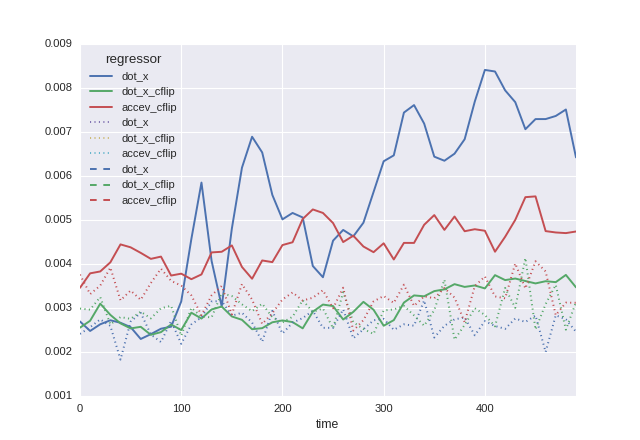

In [12]:
plot_minmax_regressors(second_level, ['dot_x', 'dot_x_cflip', 'accev_cflip'], 
                       measure, nperm=2, mode='absmean')

purely perceptual regressors

<IPython.core.display.Javascript object>


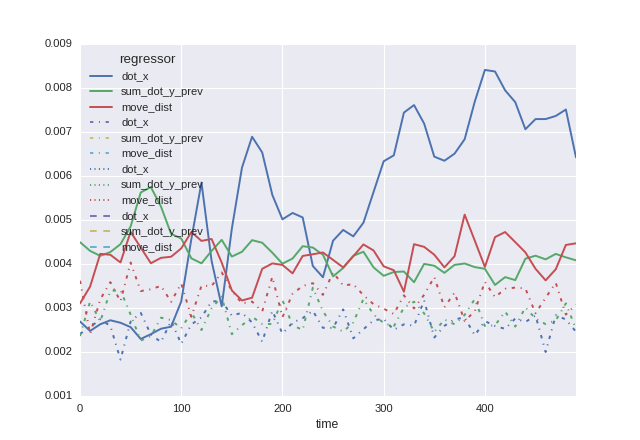

In [14]:
plot_minmax_regressors(second_level, ['dot_x', 'sum_dot_y_prev', 'move_dist'], 
                       measure, nperm=3, mode='absmean')

## Check distribution of a signal signal across time and subjects

<IPython.core.display.Javascript object>


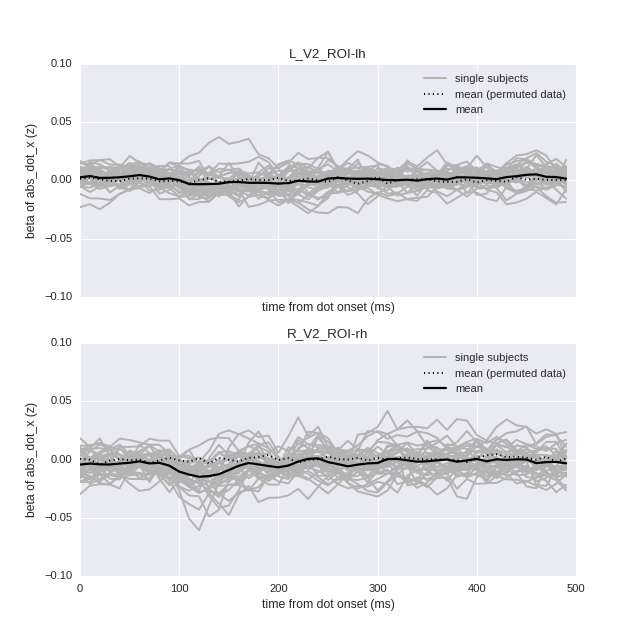

In [39]:
r_name = 'abs_dot_x'
area = 'V2'
fig, axes = plt.subplots(2, 1, sharey=True, sharex=True, figsize=[8, 8])
plot_single_signal(first_level, second_level, 'L_%s_ROI-lh'%area, r_name, axes[0])
plot_single_signal(first_level, second_level, 'R_%s_ROI-rh'%area, r_name, axes[1])
axes[1].set_ylim([-0.1, 0.1]);

<IPython.core.display.Javascript object>


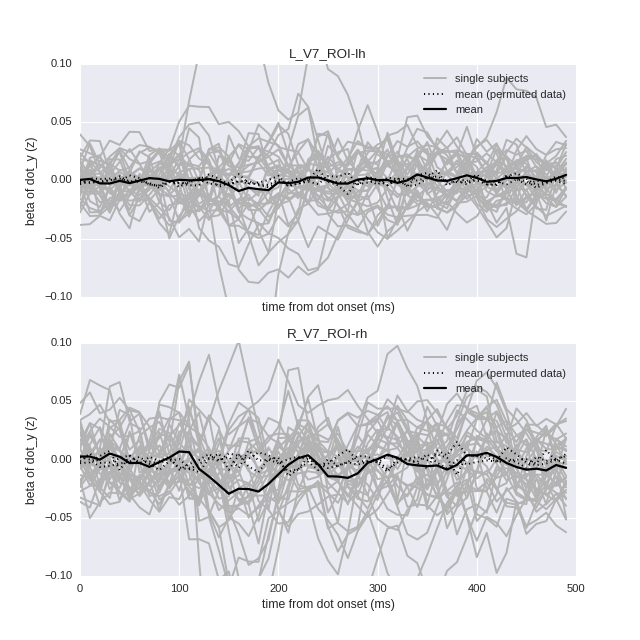

In [53]:
r_name = 'dot_y'
#area = 'LIPd'
fig, axes = plt.subplots(2, 1, sharey=True, sharex=True, figsize=[8, 8])
plot_single_signal(first_level, second_level, 'L_%s_ROI-lh'%area, r_name, axes[0])
plot_single_signal(first_level, second_level, 'R_%s_ROI-rh'%area, r_name, axes[1])
axes[1].set_ylim([-0.1, 0.1]);

<IPython.core.display.Javascript object>


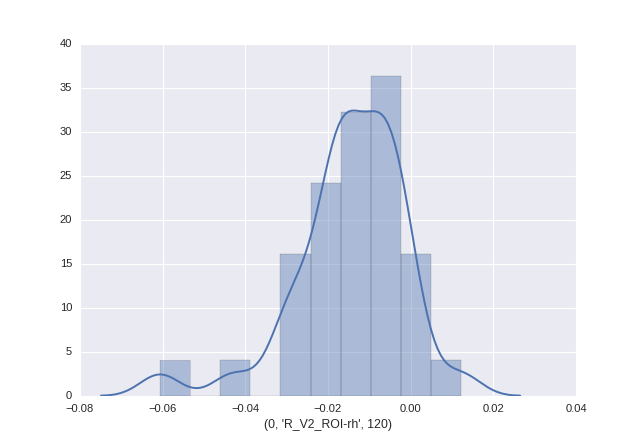

mean +- std of beta = -0.015 +- 0.014
t-value = -6.301


In [46]:
time = 120
fig, ax = plt.subplots()
fldata = first_level.loc[(0, 'R_%s_ROI-rh'%area, time), (slice(None), 'beta', r_name)]
sns.distplot(fldata)
print('mean +- std of beta = {:.3f} +- {:.3f}'.format(fldata.mean(), fldata.std()))
print('t-value = {:.3f}'.format(fldata.mean() / (fldata.std() / np.sqrt(len(fldata)))))

## Investigate topography (without baseline correction)

<IPython.core.display.Javascript object>


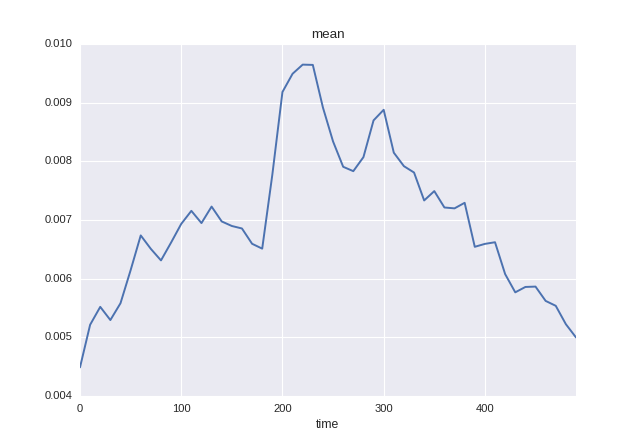

ValueError: total size of new array must be unchanged

In [75]:
show_topology_at_peaks(second_level, 'accev', 'mean', mode='absmean', order=3)

<IPython.core.display.Javascript object>


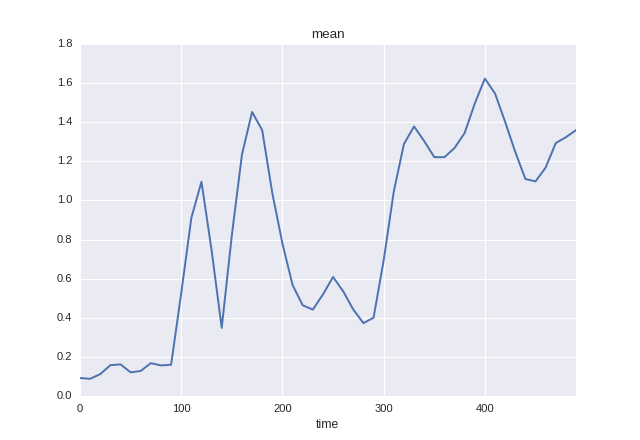

<IPython.core.display.Javascript object>


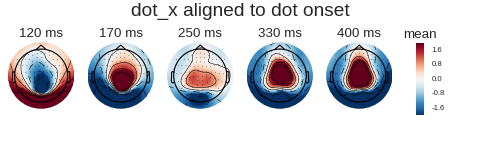

In [17]:
show_topology_at_peaks(second_level, 'dot_x', 'mean', mode='absmean', order=3, vmin=-2, vmax=2)

<IPython.core.display.Javascript object>


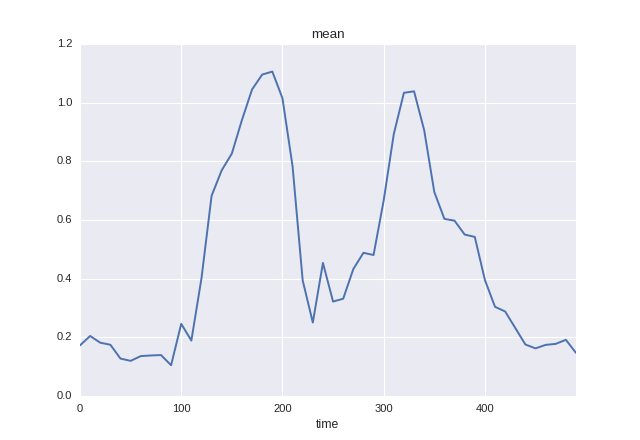

<IPython.core.display.Javascript object>


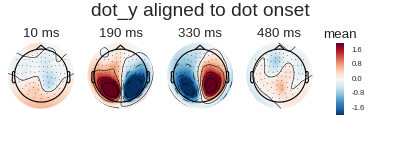

In [18]:
show_topology_at_peaks(second_level, 'dot_y', 'mean', mode='absmean', vmin=-2, vmax=2)

<IPython.core.display.Javascript object>


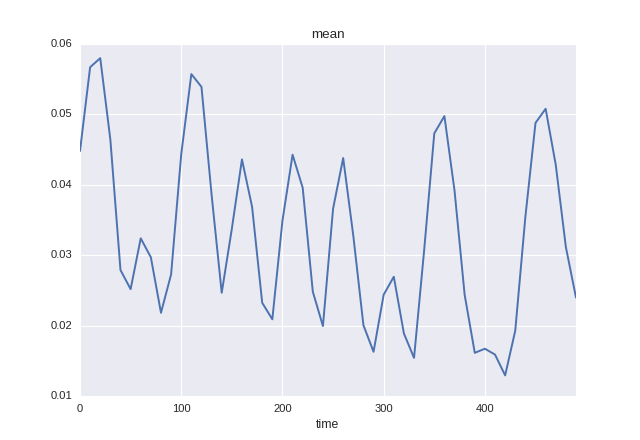

<IPython.core.display.Javascript object>


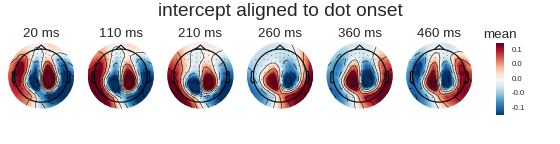

In [15]:
show_topology_at_peaks(second_level, 'intercept', 'mean', mode='absmean')

<IPython.core.display.Javascript object>


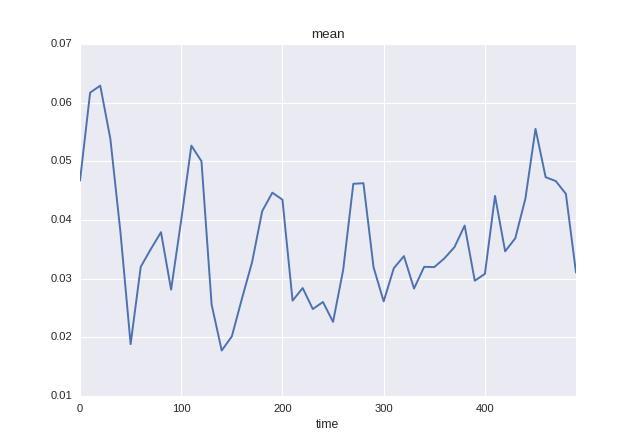

<IPython.core.display.Javascript object>


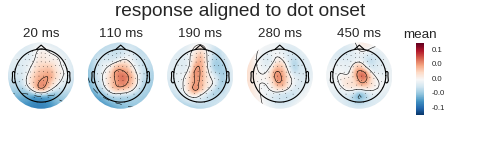

In [16]:
show_topology_at_peaks(second_level, 'response', 'mean')

# Check single subject results

In [6]:
first_level_diagnostics = pd.read_hdf(resfile, 'first_level_diagnostics')
first_level = pd.read_hdf(resfile, 'first_level')

In [12]:
first_level.columns.levels[1]

Index(['beta', 'bse'], dtype='object', name='measure')

In [16]:
sl2 = first_level.xs('beta', axis=1, level='measure').abs().mean(axis=1, level='regressor')
sl2.columns = pd.MultiIndex.from_product([['mean'], sl2.columns], names=['measure', 'regressor'])

In [17]:
sl2

measure                  mean                                           \
regressor           abs_dot_x abs_dot_y     accev accsur_pca     dot_x   
permnr channel time                                                      
0      MEG0111 0     0.022158  0.012504  0.024533   0.019484  0.019925   
               10    0.022488  0.012532  0.023444   0.019486  0.022248   
               20    0.022435  0.013733  0.024293   0.017851  0.017797   
               30    0.022644  0.015043  0.024593   0.019526  0.018390   
               40    0.023600  0.016181  0.026994   0.020993  0.022459   
               50    0.023433  0.016996  0.028071   0.020143  0.021211   
               60    0.024415  0.016914  0.032458   0.020104  0.019707   
               70    0.023440  0.015281  0.030786   0.020387  0.023479   
               80    0.022769  0.012878  0.026777   0.021327  0.021936   
               90    0.020980  0.013644  0.028592   0.021824  0.019572   
               100   0.020190  0.014850  0.027681   0.019746  0.017669   
               110   0.023361  0.016360  0.030478   0.018995  0.020706   
               120   0.024527  0.016010  0.034461   0.020332  0.023122   
               130   0.021414  0.014274  0.034417   0.019547  0.020442   
               140   0.017597  0.018806  0.033652   0.021554  0.024753   
               150   0.017374  0.024039  0.029476   0.021927  0.026715   
               160   0.018555  0.020946  0.031792   0.021616  0.028443   
               170   0.019754  0.021147  0.030950   0.022652  0.028036   
               180   0.019182  0.019710  0.033503   0.021616  0.028282   
               190   0.018583  0.017815  0.037354   0.021395  0.022876   
               200   0.017865  0.016684  0.038594   0.023677  0.021246   
               210   0.017156  0.015362  0.039711   0.027545  0.024445   
               220   0.017484  0.017648  0.041354   0.026696  0.027557   
               230   0.014749  0.021437  0.040499   0.022126  0.029691   
               240   0.016154  0.018396  0.033687   0.020626  0.026426   
               250   0.015876  0.019806  0.030013   0.019669  0.025245   
               260   0.018364  0.020088  0.034040   0.020611  0.024278   
               270   0.018079  0.016993  0.035319   0.022851  0.024178   
               280   0.021934  0.018374  0.036441   0.022122  0.025188   
               290   0.019908  0.022392  0.037218   0.020269  0.030143   
...                       ...       ...       ...        ...       ...   
5      MEG2641 200   0.022955  0.016129  0.020000   0.018347  0.015904   
               210   0.018303  0.017844  0.018402   0.018204  0.021340   
               220   0.022061  0.017334  0.016007   0.019140  0.014474   
               230   0.019969  0.017324  0.024013   0.018383  0.015008   
               240   0.021713  0.013452  0.016286   0.022685  0.016662   
               250   0.020280  0.013937  0.016386   0.020612  0.015531   
               260   0.025184  0.013193  0.016505   0.018598  0.018630   
               270   0.019006  0.017195  0.019143   0.017861  0.016480   
               280   0.020907  0.014484  0.014909   0.020747  0.018761   
               290   0.025323  0.015719  0.015030   0.017323  0.018526   
               300   0.020358  0.015214  0.020411   0.018700  0.017018   
               310   0.020996  0.017869  0.017199   0.013325  0.014941   
               320   0.019945  0.017449  0.017149   0.019696  0.017608   
               330   0.018963  0.017904  0.017821   0.018240  0.020135   
               340   0.015016  0.013771  0.015811   0.018444  0.019067   
               350   0.017917  0.015325  0.014546   0.018878  0.017495   
               360   0.019781  0.015261  0.016410   0.013542  0.020235   
               370   0.016964  0.019594  0.015949   0.017414  0.017642   
               380   0.017850  0.014603  0.015177   0.018865  0.013945   
               390   0.014656  0.013607  0.014239   0.015124  0.016424   
    

<IPython.core.display.Javascript object>


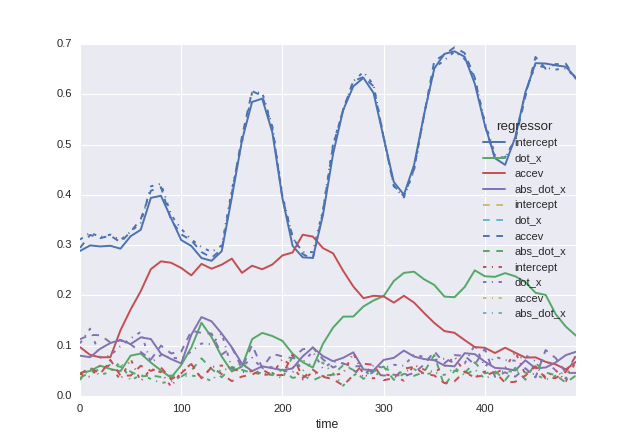

<IPython.core.display.Javascript object>


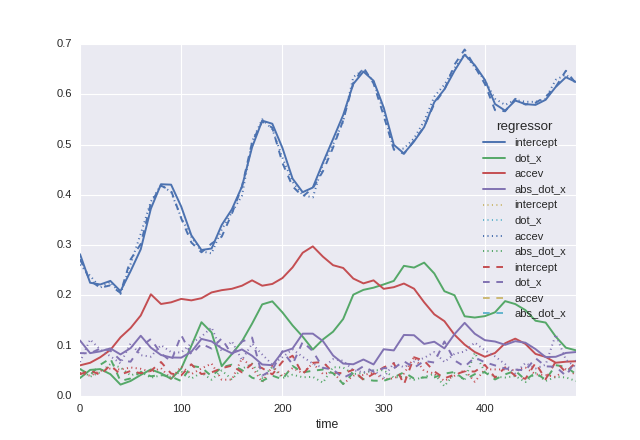

<IPython.core.display.Javascript object>


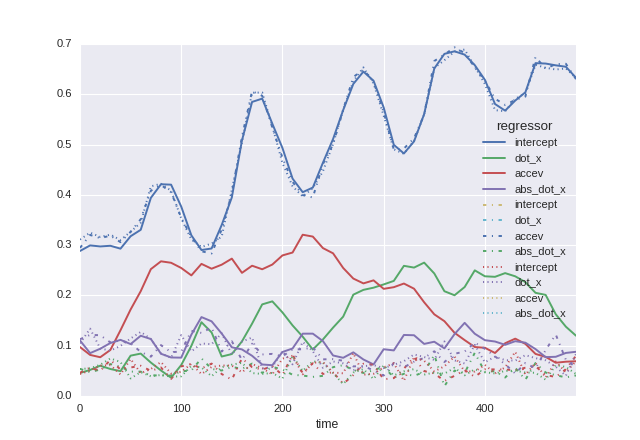

In [16]:
sub = 4
plot_minmax_regressors(first_level.xs(sub, level='subject', axis=1), 
                       reg, 'beta', nperm=2, mode='max')
plot_minmax_regressors(first_level.xs(sub, level='subject', axis=1), 
                       reg, 'beta', nperm=2, mode='min')
plot_minmax_regressors(first_level.xs(sub, level='subject', axis=1), 
                       reg, 'beta', nperm=2, mode='absmax')

## Determine relative 'power' of 20 and 60 ms peaks in intercept

In [17]:
times = first_level.index.levels[2]

# determine mean in 100 ms bins
for tbin in range(int(np.ceil(times[-1] / 100))):
    tbin_times = times[(times >= tbin * 100) & (times < (tbin+1) * 100)]
    
    binmean = first_level.loc[(0, slice(None), tbin_times), 
        (slice(None), 'beta', 'intercept')].abs().max(level='time').mean()
    
# first 200 ms


In [18]:
tbin=1
times = first_level.index.levels[2]
tbin_times = times[(times >= tbin * 100) & (times < (tbin+1) * 100)]
first_level.loc[(0, slice(None), tbin_times), (slice(None), 'beta', 'intercept')].abs().max(level='time').mean()

subject  measure  regressor
2        beta     intercept    0.389247
3        beta     intercept    0.264310
4        beta     intercept    0.424077
5        beta     intercept    0.432001
6        beta     intercept    0.558149
7        beta     intercept    0.336534
8        beta     intercept    0.398896
9        beta     intercept    0.399745
10       beta     intercept    0.294193
11       beta     intercept    0.296134
12       beta     intercept    0.620539
13       beta     intercept    0.384772
15       beta     intercept    0.426321
16       beta     intercept    0.557392
17       beta     intercept    0.504056
18       beta     intercept    0.559385
19       beta     intercept    0.409016
20       beta     intercept    0.470337
21       beta     intercept    0.324355
22       beta     intercept    0.394971
23       beta     intercept    0.330052
24       beta     intercept    0.417385
25       beta     intercept    0.604494
26       beta     intercept    0.555887
27       bet